In [ ]:
!pip install rdkit
!pip install selfies
!pip install deepchem
!pip install gensim
!pip install torch
!pip install git+https://github.com/samoturk/mol2vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.3 MB/s eta 0:00:00
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-nv8ru4zr
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-nv8ru4zr
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.8 MB/s eta 0:00:00
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14017 sha256=46bc6cdf9e9ace3563047a1e48fc96ddeb05c459a8bd9dcabd7b635986efe793
  Stored in directory: /tmp/pip-ephem-wheel-cache-0vubcyzd/wheels/b9/bd/e0/b6dd7c5e346247e8d6944e08ca1c262a908231747f4efa539d
Successfully built mol2vec


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.rdmolops import RemoveHs
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs

import selfies as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For handling the embedding layer and Mol2Vec
from gensim.models import word2vec
from gensim.models import Word2Vec
import deepchem as dc

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
df2 = pd.read_csv("training_data_JAK2.csv")
df2 = df2.drop(columns = ['Unnamed: 0'])

In [ ]:
df2

,SMILES,pIC50,Molecule
0,COCCOC1CCCN(C1)S(=O)(=O)C[C@H]1CC[C@@H](CC1)N(...,11.392545,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c398c0>
1,CC(C)COC1CCCN(C1)S(=O)(=O)C[C@H]1CC[C@@H](CC1)...,11.115205,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c39930>
2,CS(=O)(=O)N1CCCC(CC1)Nc1ncccc1-c1cnc2[nH]ccc2n1,11.050610,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c399a0>
3,COC(=O)N1CCCCC(C1)Nc1ncccc1-c1cnc2[nH]ccc2n1,10.974694,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c39a10>
4,CS(=O)(=O)N1CC[C@@H](C1)Nc1ncccc1-c1cnc2[nH]cc...,10.966576,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c39a80>
...,...,...,...
13519,Cc1cnc(Nc2ccc3B(O)OCc3c2)nc1NC1CCCCC1,7.482804,<rdkit.Chem.rdchem.Mol object at 0x7e8d15a22e30>
13520,CNC(=O)c1n[nH]c2cc(nc(NCc3cc(O)ccc3N(C)S(=O)(=...,7.482804,<rdkit.Chem.rdchem.Mol object at 0x7e8d15a22ea0>
13521,C[N+]1(CCC1)[C@H]1CC[C@@H]([C@H](C1)[N+]#[C-])...,7.481486,<rdkit.Chem.rdchem.Mol object at 0x7e8d15a22f10>
13522,O[C@H](CNC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc...,7.481486,<rdkit.Chem.rdchem.Mol object at 0x7e8d15a22f80>


In [ ]:
print("Columns in the DataFrame:")
print(df.columns.tolist())

In [ ]:
# Convert IC50 to pIC50
def ic50_to_pic50(ic50):
    # IC50 is in nM, convert to M by multiplying by 1e-9
    return -np.log10(ic50 * 1e-9)
df['IC50 (nM)'] = pd.to_numeric(df['IC50 (nM)'], errors='coerce')
df['pIC50 (nM)'] = df['IC50 (nM)'].apply(ic50_to_pic50)

In [ ]:
df.head()

In [ ]:
df2 = pd.DataFrame({'SMILES': df['Ligand SMILES'], 'pIC50': df['pIC50 (nM)']})
df2.head()

,SMILES,pIC50
0,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,inf
1,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,inf
2,FC(F)(F)Oc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)...,inf
3,FC(F)(F)Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)...,inf
4,NCc1ccnc(NS(=O)(=O)c2ccc(cc2)C2CC2C(=O)Nc2ccc3...,inf


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
df2['mol'] = df2['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

In [ ]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('model_300dim.pkl')

In [ ]:
df2 = df2[df2['SMILES'].notna()] # removing missing values
df2 = df2[df2['Molecule'].notna()] # Remove rows with invalid molecules


In [ ]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

def patched_sentences2vec(sentences, keyed_vectors, unseen=None):
    """
    Convert a list of sentences into a list of vectors, using the KeyedVectors from Gensim 4.x.
    """
    keys = set(keyed_vectors.key_to_index.keys())
    vec = []
    for sentence in sentences:
        sentence_vec = []
        for word in sentence:
            if word in keys:
                sentence_vec.append(keyed_vectors[word])
            elif unseen is not None and unseen in keys:
                sentence_vec.append(keyed_vectors[unseen])
        vec.append(np.mean(sentence_vec, axis=0) if sentence_vec else np.zeros(keyed_vectors.vector_size))
    return np.array(vec)

# Generate a molecular sentence
molecular_sentence = mol2alt_sentence(df2['mol'][1], radius = 1)
print('Molecular sentence:', molecular_sentence)

# Create a MolSentence object
mol_sentence = MolSentence(molecular_sentence)
print('\nMolSentence object:', mol_sentence)

# Convert MolSentence to vectors
df_vec = DfVec(patched_sentences2vec([mol_sentence], model.wv, unseen='UNK'))
print('\nDfVec object:', df_vec)

Molecular sentence: ['2246728737', '3537119515', '2245273601', '2423543607', '2246728737', '3537119515', '2245384272', '4003049590', '864674487', '1759589175', '2976033787', '1486598263', '2968968094', '2117068077', '2968968094', '2142032900', '2968968094', '2803848648', '2092489639', '3461773897', '2968968094', '2811394787', '999334238', '2762211251', '864942730', '2228063684', '864942730', '2228063684', '2245384272', '3598937518', '2976033787', '1730555933', '2968968094', '2117068077', '2968968094', '2117068077', '2976033787', '1795978025', '2968968094', '2117068077', '2968968094', '2117068077', '848128881', '2603759688', '2246728737', '3818546315', '3217380708', '2576005379', '2041434490', '1100037548', '3218693969', '725322217', '2041434490', '1100037548', '3217380708', '2355446912', '2132511834', '2297887526', '3218693969', '2753863138', '3218693969', '951226070', '3217380708', '3983062349']

MolSentence object: MolSentence with 64 words

DfVec object: (1, 100) dimensional vector


[10:55:32] DEPRECATION WARNING: please use MorganGenerator


In [ ]:
#Constructing sentences
df2['sentence'] = df2.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
df2['mol2vec'] = [
    DfVec(x) for x in patched_sentences2vec(df2['sentence'], model.wv, unseen='UNK')
]
X = np.array([x.vec for x in df2['mol2vec']])

X.shape

Streaming output truncated to the last 5000 lines.
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:41:09] DEPRECATION WARNING: please use MorganGenerator
[10:4

(13524, 100)

In [ ]:
df2.head()

,SMILES,pIC50,Molecule,mol,sentence,mol2vec
0,COCCOC1CCCN(C1)S(=O)(=O)C[C@H]1CC[C@@H](CC1)N(...,11.392545,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c398c0>,<rdkit.Chem.rdchem.Mol object at 0x7d003fe193f0>,"(2246728737, 3975275337, 864674487, 2222621677...","(100,) dimensional vector"
1,CC(C)COC1CCCN(C1)S(=O)(=O)C[C@H]1CC[C@@H](CC1)...,11.115205,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c39930>,<rdkit.Chem.rdchem.Mol object at 0x7d003fe19cb0>,"(2246728737, 3537119515, 2245273601, 242354360...","(100,) dimensional vector"
2,CS(=O)(=O)N1CCCC(CC1)Nc1ncccc1-c1cnc2[nH]ccc2n1,11.050610,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c399a0>,<rdkit.Chem.rdchem.Mol object at 0x7d003fe1a180>,"(2246728737, 3835273908, 999334238, 3531344838...","(100,) dimensional vector"
3,COC(=O)N1CCCCC(C1)Nc1ncccc1-c1cnc2[nH]ccc2n1,10.974694,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c39a10>,<rdkit.Chem.rdchem.Mol object at 0x7d003fe1aff0>,"(2246728737, 3975275337, 864674487, 2154935424...","(100,) dimensional vector"
4,CS(=O)(=O)N1CC[C@@H](C1)Nc1ncccc1-c1cnc2[nH]cc...,10.966576,<rdkit.Chem.rdchem.Mol object at 0x7e8d15c39a80>,<rdkit.Chem.rdchem.Mol object at 0x7d003fe1b840>,"(2246728737, 3835273908, 999334238, 3531344838...","(100,) dimensional vector"


In [ ]:
y = df2.pIC50.values.reshape((-1,1))
X = np.array([x.vec for x in df2['mol2vec']])
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)


In [ ]:
X_train.shape

(11562, 100)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

cuda:0
(11562, 100)
(1353, 100)
(609, 100)


In [ ]:
X

array([[ 0.12115224,  0.03647233, -0.01503606, ...,  0.1906106 ,
        -0.33596352, -0.02185518],
       [ 0.14088427,  0.00827719, -0.0381336 , ...,  0.22406515,
        -0.39143655, -0.00660063],
       [ 0.06516613, -0.00078492, -0.10038739, ...,  0.24682404,
        -0.28230473, -0.04597846],
       ...,
       [-0.03439131, -0.01050258, -0.03995487, ...,  0.13882327,
        -0.2638756 ,  0.03490043],
       [ 0.04605296,  0.03138447, -0.11674387, ...,  0.23861223,
        -0.32424694,  0.00679787],
       [ 0.09640756,  0.02582056, -0.04139053, ...,  0.21234725,
        -0.32382467, -0.01723253]], dtype=float32)

In [ ]:
class Net(nn.Module):
    def __init__(self, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()


        self.lstm = nn.LSTM(input_size = 100, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

In [ ]:
epochs = 750
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.50 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 128   # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer

In [ ]:
model = Net(lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

Net(
  (lstm): LSTM(100, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# Select a single sample
sample = X[10:11]  # Shape: (1, 300)

# Convert to a PyTorch tensor
sample_tensor = torch.tensor(sample, dtype=torch.float32)  # Ensure float32 for compatibility with model

# Reshape to add sequence length dimension
sample_tensor = sample_tensor.unsqueeze(1)  # Shape: (1, 1, 300)
sample_tensor = sample_tensor.to(device)
# Forward pass through the model
pred = model.forward(sample_tensor)
print(pred)

tensor([[[0.0860]]], device='cuda:0', grad_fn=<ViewBackward0>)


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add sequence length dimension
y_tensor = torch.tensor(y, dtype=torch.float32)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
model.to(device)

Net(
  (lstm): LSTM(100, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        smiles = smiles.to(device)
        labels = labels.to(device)
        # Training pass
        optimizer.zero_grad()  # Reset gradients
        output = model(smiles)  # Forward pass
        loss = criterion(output, labels)  # Compute loss
        loss.backward()  # Backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)  # Clip gradients
        optimizer.step()  # Update weights

        running_loss += loss.item()
    else:
        # Validation loss
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            X_validation_t = torch.tensor(X_validation, dtype=torch.float32).unsqueeze(1).to(device)  # Validation input
            y_validation_t = torch.tensor(y_validation, dtype=torch.float32).to(device)  # Validation labels
            validation_loss = torch.mean((y_validation_t - model(X_validation_t)) ** 2).item()

        model.train()  # Switch back to training mode

        # Adjust learning rate
        lr_scheduler.step(validation_loss)

        # Log losses
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

        # Print progress every 10 epochs
        if (e + 1) % 10 == 0:
            print(f"Epoch {e + 1}, Training loss: {train_loss:.2f}, Validation loss: {validation_loss:.2f}")

Epoch 10, Training loss: 1.81, Validation loss: 1.18
Epoch 20, Training loss: 1.47, Validation loss: 1.06
Epoch 30, Training loss: 1.28, Validation loss: 0.95
Epoch 40, Training loss: 1.15, Validation loss: 0.93
Epoch 50, Training loss: 1.07, Validation loss: 0.82
Epoch 60, Training loss: 1.01, Validation loss: 0.77
Epoch 70, Training loss: 0.98, Validation loss: 0.75
Epoch 80, Training loss: 0.96, Validation loss: 0.74
Epoch 90, Training loss: 0.93, Validation loss: 0.68
Epoch 100, Training loss: 0.92, Validation loss: 0.72
Epoch 110, Training loss: 0.90, Validation loss: 0.66
Epoch 120, Training loss: 0.88, Validation loss: 0.63
Epoch 130, Training loss: 0.86, Validation loss: 0.65
Epoch 140, Training loss: 0.86, Validation loss: 0.63
Epoch 150, Training loss: 0.84, Validation loss: 0.60
Epoch 160, Training loss: 0.84, Validation loss: 0.60
Epoch 170, Training loss: 0.82, Validation loss: 0.59
Epoch 180, Training loss: 0.81, Validation loss: 0.59
Epoch 190, Training loss: 0.81, Valid

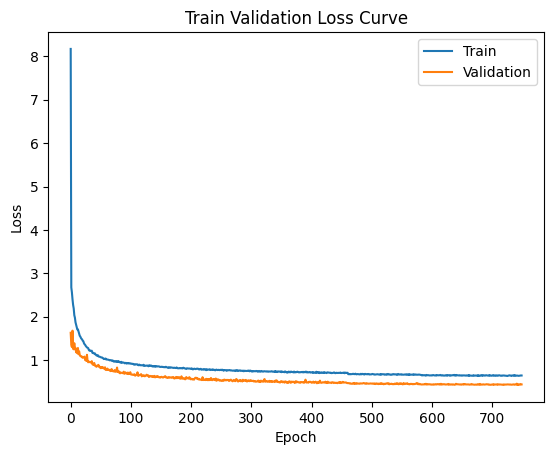

In [ ]:
plt.title("Train Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

In [ ]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
# Select a single sample

# Convert to a PyTorch tensor
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Ensure float32 for compatibility with model

# Reshape to add sequence length dimension
x_test_tensor = x_test_tensor.unsqueeze(1)  # Shape: (1, 1, 300)
x_test_tensor = x_test_tensor.to(device)

y_pred_test = model(x_test_tensor)

y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)  # test labels

torch.mean(( y_test_t - y_pred_test )**2).item()
#y_pred_test = model(X_test)

0.5281908512115479

In [ ]:
y_test_t

tensor([[8.6990],
        [6.2197],
        [5.0267],
        ...,
        [6.8477],
        [7.2596],
        [3.1669]], device='cuda:0')

In [ ]:
y_test_t.shape

torch.Size([1353, 1])

In [ ]:
y_pred_test.shape

torch.Size([1, 1353, 1])

In [ ]:
X_train.shape

(11562, 100)

In [ ]:
# Convert to a PyTorch tensor
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Ensure float32 for compatibility with model

# Reshape to add sequence length dimension
x_train_tensor = x_train_tensor.unsqueeze(1)  # Shape: (1, 1, 300)
x_train_tensor = x_train_tensor.to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)  # test labels

y_pred_train = model(x_train_tensor)
y_pred_test = model(x_test_tensor)
train_rmse = torch.mean(( y_train_tensor - y_pred_train)**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.10F\tTest RMSE: %0.10F"%(train_rmse, test_rmse))

Train RMSE: 0.5478026271	Test RMSE: 0.5281908512


In [ ]:
torch.save(model, "mol2vecLSTM.pth")

print("Entire model saved!")

Entire model saved!


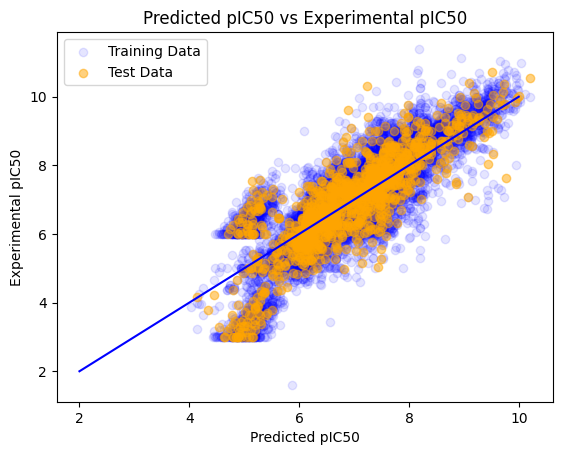

In [ ]:
plt.xlabel("Predicted pIC50")
plt.ylabel("Experimental pIC50")
plt.title("Predicted pIC50 vs Experimental pIC50")

plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_tensor.tolist()).flatten(), alpha=0.1, label="Training Data",
    color='blue')
plt.scatter(np.array(y_pred_test.tolist()).flatten(), np.array(y_test_t.tolist()).flatten(), alpha=0.5, label="Test Data",
    color='orange')

plt.legend()

plt.plot([2, 10], [2, 10], c="b")

In [ ]:
torch.save(model.state_dict(), "finalmodel.pth")

print("Model state dictionary saved!")

Model state dictionary saved!


In [ ]:
torch.save(model, "finalmodel_full.pth")

print("Entire model saved!")

Entire model saved!
